In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from glob import glob
from dotenv import load_dotenv
import os
from openai import OpenAI
import re
import string
from google import genai
import seaborn as sns
from scipy import stats
from scipy.stats import kendalltau
from bert_score import score
import evaluate
import math 

pd.set_option('display.max_rows', 4)
pd.set_option('display.max_columns', None)


In [2]:
df_news_80 = pd.read_csv('df_news_80_new16.csv')
df_dialogues_80 = pd.read_csv('df_dialogues_80_new24.csv')

# EDA

In [44]:
def word_count(text):
    if not isinstance(text, str):
        print("Error: Input must be a string.")
        return 0

    # Remove all punctuation from the string.
    # translation table that maps each punctuation character to None.
    # The str.translate() method then removes them.
    translator = str.maketrans('', '', string.punctuation)
    clean_text = text.translate(translator)
    clean_text = clean_text.lower()
    words = clean_text.split()
    return len(words)

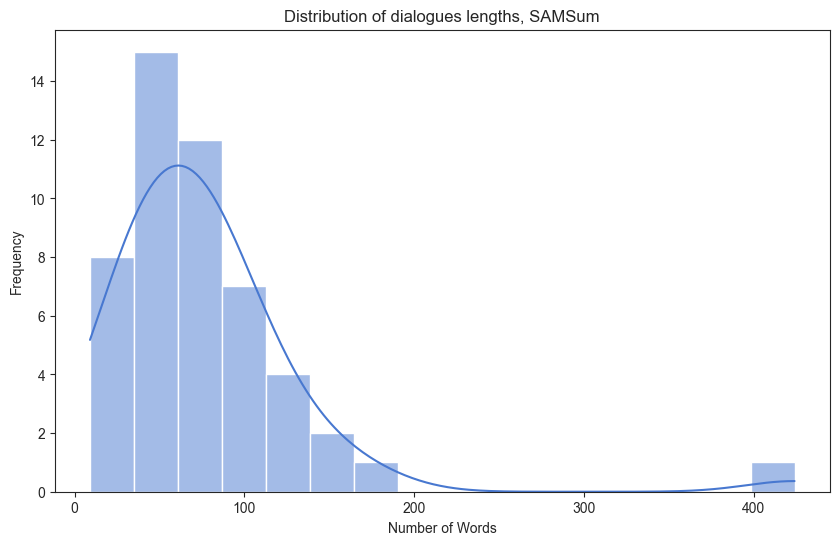

In [57]:
plt.figure(figsize=(10, 6))
sns.histplot(df_dialogues_80['dialogue_words'], kde=True)
plt.title('Distribution of dialogues lengths, SAMSum')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.savefig('distribution_word_samsum_dialogues.png')
plt.show()

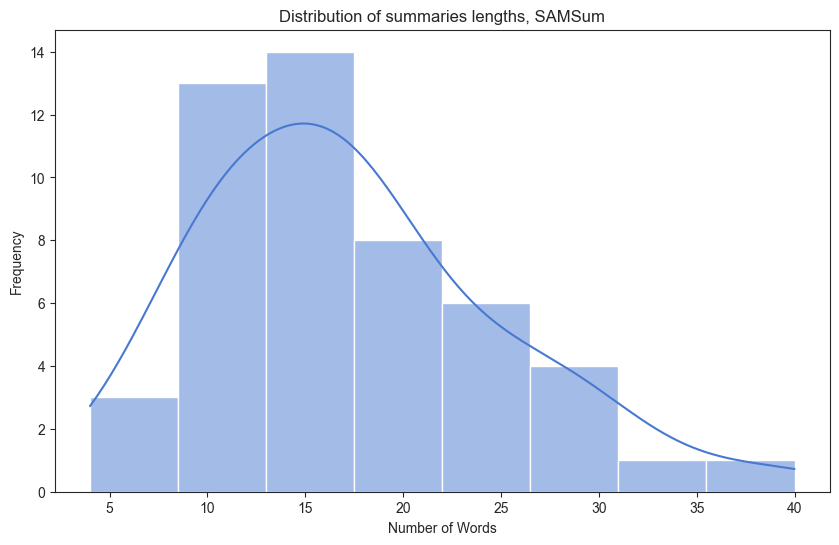

In [58]:

# Plot dialogue length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_dialogues_80['summary_words'], kde=True)
plt.title('Distribution of summaries lengths, SAMSum')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.savefig('distribution_word_samsum_summaries.png')
plt.show()


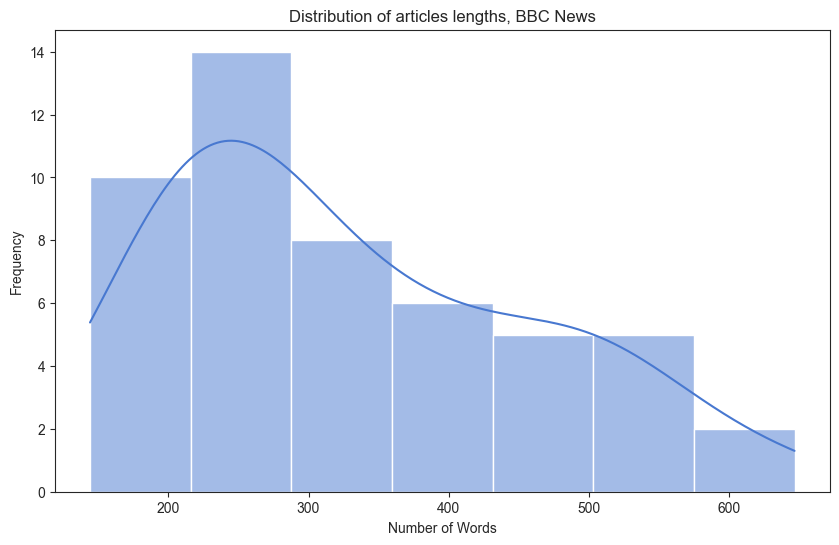

In [59]:

# Plot dialogue length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_news_80['text_words'], kde=True)
plt.title('Distribution of articles lengths, BBC News')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.savefig('distribution_word_bbc_articles.png')
plt.show()

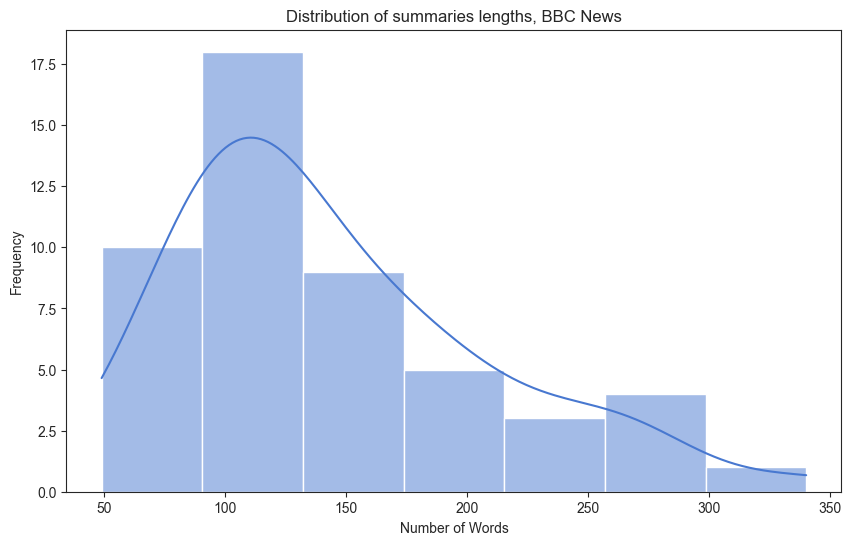

In [60]:

# Plot dialogue length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_news_80['summary_words'], kde=True)
plt.title('Distribution of summaries lengths, BBC News')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.savefig('distribution_word_bbc_summaries.png')
plt.show()

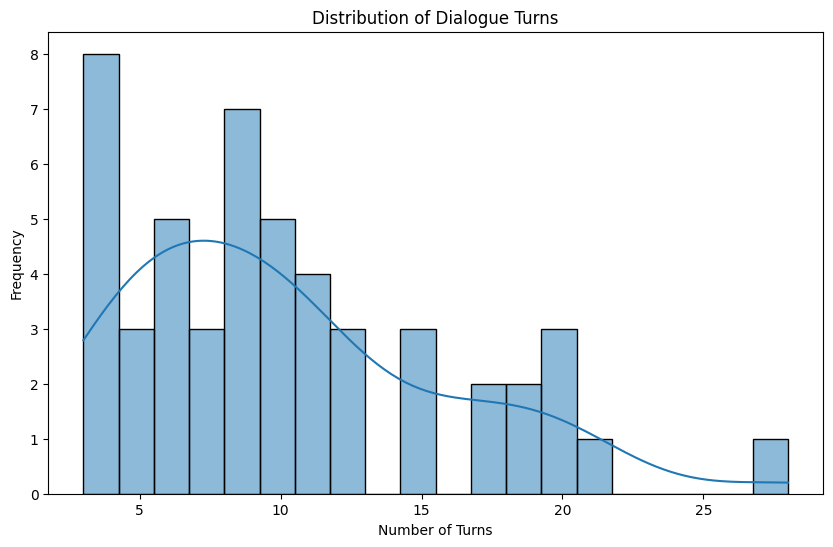

In [4]:
df_dialogues_80['turns'] = df_dialogues_80['dialogue'].apply(lambda x: len(x.split('\n')))
plt.figure(figsize=(10, 6))
sns.histplot(np.array(df_dialogues_80['turns']), kde=True, bins=20)
plt.title('Distribution of Dialogue Turns')
plt.xlabel('Number of Turns')
plt.ylabel('Frequency')
plt.savefig('distribution_turns_summaries.png')
plt.show()



# Experiment: Summaries Creation with APIs 

In [1]:
# openai API connection
OPENAI_API_KEY="api_key_here"
client_openai = OpenAI(
  api_key=OPENAI_API_KEY,
)

NameError: name 'OpenAI' is not defined

In [ ]:
# grok API connection 

api_key_grok = 'api_key_here'
client_grok = OpenAI(
  api_key=api_key_grok,
  base_url="https://api.x.ai/v1",
)

In [ ]:
# gemini api connection
api_key_gemini = 'api_key_here'
client_gemini = genai.Client(api_key=api_key_gemini)

In [ ]:
# SAMSum summary creation.
# uncomment the model you want to use and comment out the others.
# similarly with the df_dialogues_80.loc line at the end of the for loop.
# finally choose prompt_1 or prompt_2, make sure that the client get choosen prompt
# and accordingly change the df_dialogues_80.loc line at the end of the for loop (ending prefix for prompt1 or prompt.
 

for i in range(0,50):
    prompt_1 = f'''Summarize the following dialogue. The goal is to achieve an average word count of {df_dialogues_80.summary_words[i]} words. 
    A few words more or less is acceptable. Input Document:''' +  df_dialogues_80.dialogue[i]
    
    
    prompt_2 = f'''Summarize the following dialogue. The goal is to achieve an average word count of {df_dialogues_80.summary_words[i]} words. A few words more or less is acceptable. Given some examples.
    Examples: Document 1:"Louis: did you see all the people outside the book shop today?\r\nLouis: it was insane!!!\r\nSara: YES!!!\r\nSara: i saw a hugeeeeeeee crowd\r\nSara: do you know what was going on?\r\nLouis: my friend told me this writer, this new writer...\r\nLouis: i can't remember his name...\r\nLouis: the one that writes about vampires\r\nSara: dante kyle?\r\nLouis: no, the other one\r\nSara: cole grant?\r\nLouis: YES!! my friends told me he was there signing copies of his books\r\nSara: no big loss then\r\nSara: i'm not a fan of his"
    Summary 1:'There was a crowd outside the bookshop today. Cole Grant, who writes about vampires, was allegedly in the bookshop signing his books.'
    Examples: Document 2:"Brandon: Shit, I've lost my credit card!\r\nBrandon: I blocked it in the bank but it will take time before I get a new one\r\nBrandon: can you lend me $ 100 guys?\r\nLuke: sorry man, Im broke:/\r\nBrandon: I see\r\nIan: what a misfortune, dude\r\nIan: I can lend you $$, no problem\r\nBrandon: thanks, dude!"
    Summary 2:'Brandon has lost his credit card and blocked it in the bank. It will take some time before he gets a new one, and he needs money. Luke is broke, but Ian will lend Brandon some money.' 
    Examples: Document 3:"Melody: did you get your computer fixed yet?\r\nPeggy: no, im spending a lot of time using the library computers.\r\nMelody: do they know whats wrong with it? \r\nPeggy: might be something with the circuit board. they hope to have an answer tomorrow\r\nMelody: thats pretty serious. might be cheaper just to buy a new one\r\nPeggy: thats true. well see.\r\nMelody: if you need to get a new one, i highly recommend the mac model that i have\r\nPeggy: ok, good to know. i'll write if i have any questions\r\nMelody: youre probably due for a new one anyway, no?\r\nPeggy: you're right. 5 years is a long time to own one.\r\nMelody: yes, thats ancient by laptop standards\r\nPeggy: ok. i might just not bother getting it repaired after all.\r\nMelody: sounds like a good idea"
    Summary 3:"Melody's 5-year-old laptop is broken. Tomorrow she'll know what's wrong. She won't be repairing it, because her laptop is too old. Instead, she'll buy a new one." 
    Input Document:  ''' +  df_dialogues_80.dialogue[i]


    # gemini 2.5 pro part
    '''
        response = client.models.generate_content(
            model="gemini-2.5-pro", contents=prompt_1
            )
        answer = response.text
    '''

    # gemini 1.5 flash part
    
    response = client.models.generate_content(
        model="gemini-1.5-flash", contents= prompt_1
    )
    answer = response.text


    # gpt-5 part
     '''
        response = client.responses.create(
        model="gpt-5",
            input=prompt
        )
        answer = response.output_text
    '''


    # grok part
    ''' 
        completion = client.chat.completions.create(
        model="grok-4",
            messages=[
                {"role": "user", "content": prompt_1}
            ]
        )
        answer = completion.choices[0].message.content
    '''


    df_dialogues_80.loc[i, 'summary_gemini_prompt1'] = answer
    #df_dialogues_80.loc[i, 'summary_gemini_flash_prompt1'] = answer
    #df_dialogues_80.loc[i, 'summary_openai_prompt1'] = answer
    #df_dialogues_80.loc[i, 'summary_grok_prompt1'] = answer

    print("done " + str(i))


In [ ]:
# BBC News summary creation.
# uncomment the model you want to use and comment out the others.
# similarly with the df_dialogues_80.loc line at the end of the for loop.
# finally choose prompt_1 or prompt_2, make sure that the client get choosen prompt
# and accordingly change the df_dialogues_80.loc line at the end of the for loop (ending prefix for prompt1 or prompt.
 

for i in range(5,50):
    prompt_1 = f'''Write a comprehensive summary of this news article. The goal is to achieve an average word count of {df_news_80.summary_words[i]} words. A few words more
    or less is acceptable. Given some examples. ''' +  df_news_80.text[i]

    prompt_2 = f'''Write a comprehensive summary of this news article. The goal is to achieve an average word count of {df_news_80.summary_words[i]} words. A few words more
    or less is acceptable. Given some examples.
    Examples: Document 1: 'Ad sales boost Time Warner profitQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL\'s existing customers for high-speed broadband. TimeWarner also has to restate 2000 and 2003 results following a probe by the US Securities Exchange Commission (SEC), which is close to concluding.Time Warner\'s fourth quarter profits were slightly better than analysts\' expectations. But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results. For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn. "Our financial performance was strong, meeting or exceeding all of our full-year objectives and greatly enhancing our flexibility," chairman and chief executive Richard Parsons said. For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.TimeWarner is to restate its accounts as part of efforts to resolve an inquiry into AOL by US market regulators. It has already offered to pay $300m to settle charges, in a deal that is under review by the SEC. The company said it was unable to estimate the amount it needed to set aside for legal reserves, which it previously set at $500m. It intends to adjust the way it accounts for a deal with German music publisher Bertelsmann\'s purchase of a stake in AOL Europe, which it had reported as advertising revenue. It will now book the sale of its stake in AOL Europe as a loss on the value of that stake.'
    Summary 1: "TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn.Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues.Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters.Time Warner's fourth quarter profits were slightly better than analysts' expectations."
    Examples: Document 2: 'Dollar gains on Greenspan speechThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.And Alan Greenspan highlighted the US government\'s willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan\'s speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. "I think the chairman\'s taking a much more sanguine view on the current account deficit than he\'s taken for some time," said Robert Sinche, head of currency strategy at Bank of America in New York. "He\'s taking a longer-term view, laying out a set of conditions under which the current account deficit can improve this year and next."Worries about the deficit concerns about China do, however, remain. China\'s currency remains pegged to the dollar and the US currency\'s sharp falls in recent months have therefore made Chinese export prices highly competitive. But calls for a shift in Beijing\'s policy have fallen on deaf ears, despite recent comments in a major Chinese newspaper that the "time is ripe" for a loosening of the peg. The G7 meeting is thought unlikely to produce any meaningful movement in Chinese policy. In the meantime, the US Federal Reserve\'s decision on 2 February to boost interest rates by a quarter of a point - the sixth such move in as many months - has opened up a differential with European rates. The half-point window, some believe, could be enough to keep US assets looking more attractive, and could help prop up the dollar. The recent falls have partly been the result of big budget deficits, as well as the US\'s yawning current account gap, both of which need to be funded by the buying of US bonds and assets by foreign firms and governments. The White House will announce its budget on Monday, and many commentators believe the deficit will remain at close to half a trillion dollars.'
    Summary 2: 'The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.China\'s currency remains pegged to the dollar and the US currency\'s sharp falls in recent months have therefore made Chinese export prices highly competitive.Market concerns about the deficit has hit the greenback in recent months."I think the chairman\'s taking a much more sanguine view on the current account deficit than he\'s taken for some time," said Robert Sinche, head of currency strategy at Bank of America in New York.The recent falls have partly been the result of big budget deficits, as well as the US\'s yawning current account gap, both of which need to be funded by the buying of US bonds and assets by foreign firms and governments."He\'s taking a longer-term view, laying out a set of conditions under which the current account deficit can improve this year and next."'
    Examples: Document 3: 'Yukos unit buyer faces loan claimThe owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan.State-owned Rosneft bought the Yugansk unit for $9.3bn in a sale forced by Russia to part settle a $27.5bn tax claim against Yukos. Yukos\' owner Menatep Group says it will ask Rosneft to repay a loan that Yugansk had secured on its assets. Rosneft already faces a similar $540m repayment demand from foreign banks. Legal experts said Rosneft\'s purchase of Yugansk would include such obligations. "The pledged assets are with Rosneft, so it will have to pay real money to the creditors to avoid seizure of Yugansk assets," said Moscow-based US lawyer Jamie Firestone, who is not connected to the case. Menatep Group\'s managing director Tim Osborne told the Reuters news agency: "If they default, we will fight them where the rule of law exists under the international arbitration clauses of the credit."Rosneft officials were unavailable for comment. But the company has said it intends to take action against Menatep to recover some of the tax claims and debts owed by Yugansk. Yukos had filed for bankruptcy protection in a US court in an attempt to prevent the forced sale of its main production arm. The sale went ahead in December and Yugansk was sold to a little-known shell company which in turn was bought by Rosneft. Yukos claims its downfall was punishment for the political ambitions of its founder Mikhail Khodorkovsky and has vowed to sue any participant in the sale.'
    Summary 3: 'Yukos\' owner Menatep Group says it will ask Rosneft to repay a loan that Yugansk had secured on its assets.State-owned Rosneft bought the Yugansk unit for $9.3bn in a sale forced by Russia to part settle a $27.5bn tax claim against Yukos.The sale went ahead in December and Yugansk was sold to a little-known shell company which in turn was bought by Rosneft.But the company has said it intends to take action against Menatep to recover some of the tax claims and debts owed by Yugansk."The pledged assets are with Rosneft, so it will have to pay real money to the creditors to avoid seizure of Yugansk assets," said Moscow-based US lawyer Jamie Firestone, who is not connected to the case.'
    Input Document:  ''' +  df_news_80.text[i]

    # gemini 2.5 pro part
    '''
        response = client.models.generate_content(
            model="gemini-2.5-pro", contents=prompt_1
            )
        answer = response.text
    '''

    # gemini 1.5 flash part
    
    response = client.models.generate_content(
        model="gemini-1.5-flash", contents= prompt_1
    )
    answer = response.text


    # gpt-5 part
     '''
        response = client.responses.create(
        model="gpt-5",
            input=prompt
        )
        answer = response.output_text
    '''


    # grok part
    ''' 
        completion = client.chat.completions.create(
        model="grok-4",
            messages=[
                {"role": "user", "content": prompt_1}
            ]
        )
        answer = completion.choices[0].message.content
    '''


    df_news_80.loc[i, 'summary_gemini_prompt1'] = answer
    #df_news_80.loc[i, 'summary_gemini_flash_prompt1'] = answer
    #df_news_80.loc[i, 'summary_openai_prompt1'] = answer
    #df_news_80.loc[i, 'summary_grok_prompt1'] = answer
    print("done " + str(i))

# evaluation metric computation

## bertscore

In [ ]:
# BBC News
# uncomment both lines to use, they are commented to avoid accidental execution
# to calculate for different model and accordingly put the value it different column
# 2 changes have to be made. One is inside candidates variable, changing the column choosen
# Another one is when putting into dataframe in last line.

for i in range(0,50):
    candidates = [df_news_80.summary_openai_prompt2[i]]
    references = [df_news_80.summary[i]]
    # P, R, F1 = score(candidates, references, lang="en", verbose=True)

    # df_news_80.loc[i, 'bertscore_openai_prompt2'] = F1.item()

In [ ]:
# SAMSum
# uncomment both lines to use, they are commented to avoid accidental execution
# to calculate for different model and accordingly put the value it different column
# 2 changes have to be made. One is inside candidates variable, changing the column choosen
# Another one is when putting into dataframe in last line.

for i in range(0,50):
    candidates = [df_dialogues_80.summary_gemini_flash_prompt1[i]]
    references = [df_dialogues_80.summary[i]]
    # P, R, F1 = score(candidates, references, lang="en", verbose=True)

    # df_dialogues_80.loc[i, 'bertscore_gemini_flash_prompt1'] = F1.item()

## g-eval

In [ ]:
# open ai api connection
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI()

In [ ]:
## BBC News g-eval evaluation
# uncomment the lines with api client to use, they are commented to avoid accidental execution

# to calculate for different model and accordingly put the value it different column there needs to be 2 changes
# 2 changes have to be made. One is inside prompt variable, changing the summary at the end of the prompt.
# Another one is when putting into dataframe in last line.
for i in range(0,50):
    
    prompt = '''You will be given one summary written for a news article. Your task is to rate the summary on one metric. Please make sure you read and understand these instructions carefully. Please keep this document open while reviewing, and refer to it as needed.

    Evaluation Criteria: Coherence (1-5) - the collective quality of all sentences. We align this dimension with the DUC quality question of structure and coherence whereby ”the summary should be well-structured and well-organized. The summary should not just be a heap of related information, but should build from sentence to sentence to a coherent body of information about a topic.”

    1. Read the news article carefully and identify the main topic and key points.
    2. Read the summary and compare it to the news article. Check if the summary covers the main topic and key points of the news article, and if it presents them in a clear and logical order.
    3. Assign a score for coherence on a scale of 1 to 5, where 1 is the lowest and 5 is the highest based on the EvaluationCriteria. Output only 1 number, the score.
    News article: ''' + df_news_80.text[i]  + " Summary: " + df_news_80.summary_gemini_flash_prompt2[i] 
    
    
    '''
        completion = client.chat.completions.create(
        model="gpt-4.1-nano-2025-04-14",
        messages=[
            {"role": "user", "content": prompt}
        ],
        logprobs=True,
        top_logprobs=5
    )
    '''

    score = 0
    total_logprob = 0
    token_logprobs = completion.choices[0].logprobs.content
    for token_info in token_logprobs:
        for top_prob in token_info.top_logprobs:
                top_token_probability = math.exp(top_prob.logprob)
                if top_prob.token.isdigit() and int(top_prob.token) in [1,2,3,4,5]:
                    score = score + int(top_prob.token) * float(top_token_probability)
                    total_logprob += top_token_probability

    normalized_score = score / total_logprob if total_logprob > 0 else 0
    score_01 = normalized_score / 5
    df_news_80.loc[i, 'g_eval_gemini_flash_prompt2'] = score_01

In [ ]:
# SAMSum g-eval evaluation
# uncomment the lines with api client to use, they are commented to avoid accidental execution

# to calculate for different model and accordingly put the value it different column there needs to be 2 changes
# 2 changes have to be made. One is inside prompt variable, changing the summary at the end of the prompt.
# Another one is when putting into dataframe in last line.


for i in range(0,50):
    
    prompt = '''You will be given one summary written for a dialogue. Your task is to ratethe summary on one metric. Please make sure you read and understand these instructions carefully. Pleasekeep this document open while reviewing, and refer to it as needed. 
    Evaluation Criteria:
    Coherence (1-5) - the collective quality
    of all sentences. We align this dimension with the DUC quality question of structure and coherence whereby ”the summary should be well-structured and well-organized. The summary should not just be a heap of related information, but should build from sentence to sentence to a coherent body of information about a topic.”
    1. Read the dialogue carefully and identify the main topic and key points.
    2. Read the summary and compare it to the dialogue. Check if the summary
    covers the main topic and key points of the dialogue, and if it presents them in a clear and logical order.
    3. Assign a score for coherence on a scale of 1 to 5, where 1 is the lowest and 5 is the highest based on the Evaluation Criteria. Output only 1 number, the score.
    Dialogue: ''' + df_dialogues_80.dialogue[i] + " Summary: " + df_dialogues_80.summary_openai_prompt2[i] 
    
    
    '''
        completion = client.chat.completions.create(
        model="gpt-4.1-nano-2025-04-14",
        messages=[
            {"role": "user", "content": prompt}
        ],
        logprobs=True,
        top_logprobs=5
    )
    '''
    
    score = 0
    total_logprob = 0
    token_logprobs = completion.choices[0].logprobs.content
    for token_info in token_logprobs:
        for top_prob in token_info.top_logprobs:
                top_token_probability = math.exp(top_prob.logprob)
                if top_prob.token.isdigit() and int(top_prob.token) in [1,2,3,4,5]:
                    score = score + int(top_prob.token) * float(top_token_probability)
                    total_logprob += top_token_probability

    normalized_score = score / total_logprob if total_logprob > 0 else 0
    score_01 = normalized_score / 5
    df_dialogues_80.loc[i, 'g_eval_openai_prompt2'] = score_01
    print("done " + str(i))

## meteor

In [23]:
meteor = evaluate.load('meteor')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\miktw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\miktw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\miktw\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# BBC News
# uncomment both lines to use, they are commented to avoid accidental execution
# to calculate for different model and accordingly put the value it different column
# 2 changes have to be made. One is inside candidates variable, changing the column choosen
# Another one is when putting into dataframe in last line.

for i in range(0,50):
    candidates = [df_news_80.summary_grok_prompt2[i]]
    references = [df_news_80.summary[i]]
    #results = meteor.compute(predictions=candidates, references=references)

    #df_news_80.loc[i, 'meteor_grok_prompt2'] = results['meteor']

In [ ]:
# SAMSum
# uncomment both lines to use, they are commented to avoid accidental execution
# to calculate for different model and accordingly put the value it different column
# 2 changes have to be made. One is inside candidates variable, changing the column choosen
# Another one is when putting into dataframe in last line.

for i in range(0,50):
    candidates = [df_dialogues_80.summary_grok_prompt2[i]]
    references = [df_dialogues_80.summary[i]]
    #results = meteor.compute(predictions=candidates, references=references)

    #df_dialogues_80.loc[i, 'meteor_grok_prompt2'] = results['meteor']

# Correlation matrices between metrics

In [ ]:
# this is a creation of matrices for computing correlation between matrices.
# As has been written in thesis, we Choose sentence-level correlation.
# In the last output it can be seen that the correlation is computed between 3 metrics of 50 sample size.
# 50 sample size  was the original amount of summaries.
# We create new 4 dataframe that are aggregated on mean, as have been discussed in thesis
# for the simplicity of presentation, altough it's not fully correct way to do it
# the overrall dynamic and relationship between correlation are preserved on this aggregated dataframes. 
news_grouped_prompt1 = pd.DataFrame({
    # Get all columns with 'g_eval' and calculate the mean for each row.
    'g_eval': df_news_prompt1.filter(like='g_eval', axis=1).mean(axis=1),
    # Get all columns with 'bertscore' and calculate the mean for each row.
    'bertscore': df_news_prompt1.filter(like='bertscore', axis=1).mean(axis=1),
    # Get all columns with 'meteor' and calculate the mean for each row.
    'meteor': df_news_prompt1.filter(like='meteor', axis=1).mean(axis=1)
})

news_grouped_prompt2 = pd.DataFrame({
    # Get all columns with 'g_eval' and calculate the mean for each row.
    'g_eval': df_news_prompt2.filter(like='g_eval', axis=1).mean(axis=1),
    # Get all columns with 'bertscore' and calculate the mean for each row.
    'bertscore': df_news_prompt2.filter(like='bertscore', axis=1).mean(axis=1),
    # Get all columns with 'meteor' and calculate the mean for each row.
    'meteor': df_news_prompt2.filter(like='meteor', axis=1).mean(axis=1)
})

dialogues_grouped_prompt1 = pd.DataFrame({
    # Get all columns with 'g_eval' and calculate the mean for each row.
    'g_eval': df_dialogues_prompt1.filter(like='g_eval', axis=1).mean(axis=1),
    # Get all columns with 'bertscore' and calculate the mean for each row.
    'bertscore': df_dialogues_prompt1.filter(like='bertscore', axis=1).mean(axis=1),
    # Get all columns with 'meteor' and calculate the mean for each row.
    'meteor': df_dialogues_prompt1.filter(like='meteor', axis=1).mean(axis=1)
})

dialogues_grouped_prompt2 = pd.DataFrame({
    # Get all columns with 'g_eval' and calculate the mean for each row.
    'g_eval': df_dialogues_prompt2.filter(like='g_eval', axis=1).mean(axis=1),
    # Get all columns with 'bertscore' and calculate the mean for each row.
    'bertscore': df_dialogues_prompt2.filter(like='bertscore', axis=1).mean(axis=1),
    # Get all columns with 'meteor' and calculate the mean for each row.
    'meteor': df_dialogues_prompt2.filter(like='meteor', axis=1).mean(axis=1)
})
news_grouped_prompt1

,g_eval,bertscore,meteor
0,0.791577,0.881631,0.308997
1,0.799506,0.866731,0.300833
2,0.788410,0.881294,0.295104
3,0.765090,0.876576,0.319019
...,...,...,...
46,0.800476,0.888788,0.342076
47,0.800563,0.890487,0.350010
48,0.783597,0.884268,0.346348
49,0.785396,0.877521,0.358282


In [ ]:
# correlation matrices and p values creation for SAMSum on prompt 1
p_values_dialogues_prompt1 = pd.DataFrame(index=dialogues_grouped_prompt1.columns, columns=dialogues_grouped_prompt1.columns)
correlation_matrix_dialogues_k_1 = pd.DataFrame(index=dialogues_grouped_prompt1.columns, columns=dialogues_grouped_prompt1.columns)
for col1 in dialogues_grouped_prompt1.columns:
    for col2 in dialogues_grouped_prompt1.columns:
        if col1 == col2:
            p_values_dialogues_prompt1.loc[col1, col2] = 0.0  # p-value is 0 for self-correlation
        else:
            corr, p_value = kendalltau(dialogues_grouped_prompt1[col1], dialogues_grouped_prompt1[col2])
            p_values_dialogues_prompt1.loc[col1, col2] = p_value
            correlation_matrix_dialogues_k_1.loc[col1, col2] = corr

In [ ]:
# correlation matrices and p values creation for SAMSum on prompt 2

p_values_dialogues_prompt2 = pd.DataFrame(index=dialogues_grouped_prompt2.columns, columns=dialogues_grouped_prompt2.columns)
correlation_matrix_dialogues_k_2 = pd.DataFrame(index=dialogues_grouped_prompt2.columns, columns=dialogues_grouped_prompt2.columns)
for col1 in dialogues_grouped_prompt2.columns:
    for col2 in dialogues_grouped_prompt2.columns:
        if col1 == col2:
            p_values_dialogues_prompt2.loc[col1, col2] = 0.0  # p-value is 0 for self-correlation
        else:
            corr, p_value = kendalltau(dialogues_grouped_prompt2[col1], dialogues_grouped_prompt2[col2])
            p_values_dialogues_prompt2.loc[col1, col2] = p_value
            correlation_matrix_dialogues_k_2.loc[col1, col2] = corr

In [ ]:
# correlation matrices and p values creation for BBC News on prompt 1

p_values_news_prompt1 = pd.DataFrame(index=news_grouped_prompt1.columns, columns=news_grouped_prompt1.columns)
correlation_matrix_news_k_1 = pd.DataFrame(index=news_grouped_prompt1.columns, columns=news_grouped_prompt1.columns)

for col1 in news_grouped_prompt1.columns:
    for col2 in news_grouped_prompt1.columns:
        if col1 == col2:
            p_values_news_prompt1.loc[col1, col2] = 0.0  # p-value is 0 for self-correlation
        else:
            corr, p_value = kendalltau(news_grouped_prompt1[col1], news_grouped_prompt1[col2])
            p_values_news_prompt1.loc[col1, col2] = p_value
            correlation_matrix_news_k_1.loc[col1, col2] = corr

In [ ]:
# correlation matrices and p values creation for BBC News on prompt 1

p_values_news_prompt2 = pd.DataFrame(index=news_grouped_prompt2.columns, columns=news_grouped_prompt2.columns)
correlation_matrix_news_k_2 = pd.DataFrame(index=news_grouped_prompt2.columns, columns=news_grouped_prompt2.columns)

for col1 in news_grouped_prompt2.columns:
    for col2 in news_grouped_prompt2.columns:
        if col1 == col2:
            p_values_news_prompt2.loc[col1, col2] = 0.0  # p-value is 0 for self-correlation
        else:
            corr, p_value = kendalltau(news_grouped_prompt2[col1], news_grouped_prompt2[col2])
            p_values_news_prompt2.loc[col1, col2] = p_value
            correlation_matrix_news_k_2.loc[col1, col2] = corr

In [37]:
def save_two_matrix_heatmaps(matrix1, matrix2, path, titles=["Matrix 1", "Matrix 2"], annot_kws_fontsize=20, cmap='viridis'):
    """
    Saves heatmaps of two given matrices side-by-side, displaying only the
    lower triangle. This is useful for symmetric matrices to avoid redundancy.

    Args:
        matrix1 (np.ndarray or list of lists): The first matrix for the left heatmap.
        matrix2 (np.ndarray or list of lists): The second matrix for the right heatmap.
        path (str): The file path to save the combined image.
        titles (list): A list of two strings for the titles of the heatmaps.
        annot_kws_fontsize (int): Font size for the annotations on the heatmaps.
        cmap (str): The colormap to use for the heatmaps.
    """
    # Convert the inputs to pandas DataFrames
    df1 = pd.DataFrame(matrix1)
    df2 = pd.DataFrame(matrix2)
    
    # Create masks to hide the upper triangle of each matrix
    # The mask will have True values for the parts we want to hide
    mask1 = np.triu(np.ones_like(df1, dtype=bool), k=1)
    mask2 = np.triu(np.ones_like(df2, dtype=bool), k =1)
    
    # Set up the figure and axes to display two plots side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Create the first heatmap on the left subplot
    sns.heatmap(
        df1,
        mask=mask1,              # Apply the mask to hide the upper triangle
        ax=axes[0],              # Specify the subplot
        annot=True,              # Display values on the heatmap
        cmap='Blues',
        fmt=".2f",               # Format the annotations to two decimal places
        linewidths=.5,           # Add lines to separate cells
        cbar=True,               # Show the color bar
        annot_kws={'fontsize': annot_kws_fontsize}
    )
    axes[0].set_title(titles[0], fontsize=16)
    
    # Create the second heatmap on the right subplot
    sns.heatmap(
        df2,
        mask=mask2,              # Apply the mask
        ax=axes[1],              # Specify the subplot
        annot=True,
        cmap='Blues',
        fmt=".2f",
        linewidths=.5,
        cbar=True,
        annot_kws={'fontsize': annot_kws_fontsize}
    )
    axes[1].set_title(titles[1], fontsize=16)
    
    # Adjust layout to prevent titles and labels from overlapping
    plt.tight_layout()
    
    # Save the combined figure
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    plt.close(fig) # Close the figure to free up memory


In [ ]:
p_values_dialogues_prompt1 = p_values_dialogues_prompt1.apply(pd.to_numeric, errors='coerce')
p_values_dialogues_prompt2= p_values_dialogues_prompt2.apply(pd.to_numeric, errors='coerce')
p_values_news_prompt1 = p_values_news_prompt1.apply(pd.to_numeric, errors='coerce')
p_values_news_prompt2= p_values_news_prompt2.apply(pd.to_numeric, errors='coerce')

In [ ]:
save_two_matrix_heatmaps(correlation_matrix_news_k_1, p_values_news_prompt1, 'correlation_BBC_prompt1_copy.png', titles=['Correlation matrix for BBC news with prompt1', 'p-values for BBC news with prompt1 of kendall tau'])
save_two_matrix_heatmaps(correlation_matrix_news_k_2, p_values_news_prompt2, 'correlation_BBC_prompt2_copy.png', titles=['Correlation matrix for BBC news with prompt2', 'p-values for BBC news with prompt2 of kendall tau'])
save_two_matrix_heatmaps(correlation_matrix_dialogues_k_1, p_values_dialogues_prompt1, 'correlation_samsum_prompt1_copy.png', titles=['Correlation matrix for SAMSum with prompt1', 'p-values for SAMSum with prompt1 of kendall tau'])
save_two_matrix_heatmaps(correlation_matrix_dialogues_k_2, p_values_dialogues_prompt2, 'correlation_samsum_prompt2_copy.png', titles=['Correlation matrix for SAMSum with prompt2', 'p-values for SAMSum with prompt2 of kendall tau'])


# Final results

In [ ]:
aggregated_data = {}
metrics = ['g_eval', 'bertscore', 'meteor']
models = ['gemini', 'grok', 'openai', 'gemini_flash']

for model in models:
    aggregated_data[model] = {}
    for metric in metrics:
        # Find all columns for the current model and metric.
        cols_to_avg = [col for col in df_news_prompt1.columns if model in col and metric in col]
        
        # Calculate the average across the rows for these columns.
        if cols_to_avg:
            aggregated_data[model][f'Average Score_({metric})'] = np.mean(df_news_prompt1[cols_to_avg].mean())

# Convert the dictionary to a DataFrame in the desired format.
decision_matrix_news_prompt1 = pd.DataFrame(aggregated_data).T.rename_axis('Model')
decision_matrix_news_prompt1= decision_matrix_news_prompt1.rename({'gemini': 'gemini-2.5-pro_prompt1', 'grok': 'grok-4_prompt1', 'openai' : 'gpt-5_prompt1', 'gemini_flash' : 'gemini_flash-1.5_prompt1'}, axis='index')

In [ ]:
for model in models:
    aggregated_data[model] = {}
    for metric in metrics:
        # Find all columns for the current model and metric.
        cols_to_avg = [col for col in df_news_prompt2.columns if model in col and metric in col]
        
        # Calculate the average across the rows for these columns.
        if cols_to_avg:
            aggregated_data[model][f'Average Score_({metric})'] = np.mean(df_news_prompt2[cols_to_avg].mean())

# Convert the dictionary to a DataFrame in the desired format.
decision_matrix_news_prompt2 = pd.DataFrame(aggregated_data).T.rename_axis('Model')
decision_matrix_news_prompt2 = decision_matrix_news_prompt2.rename({'gemini': 'gemini-2.5-pro_prompt2', 'grok': 'grok-4_prompt2', 'openai' : 'gpt-5_prompt2', 'gemini_flash' : 'gemini_flash-1.5_prompt2'}, axis='index')

In [ ]:
for model in models:
    aggregated_data[model] = {}
    for metric in metrics:
        # Find all columns for the current model and metric.
        cols_to_avg = [col for col in df_dialogues_prompt1.columns if model in col and metric in col]
        
        # Calculate the average across the rows for these columns.
        if cols_to_avg:
            aggregated_data[model][f'Average Score_({metric})'] = np.mean(df_dialogues_prompt1[cols_to_avg].mean())

# Convert the dictionary to a DataFrame in the desired format.
decision_matrix_dialogues_prompt1 = pd.DataFrame(aggregated_data).T.rename_axis('Model')
decision_matrix_dialogues_prompt1 = decision_matrix_dialogues_prompt1.rename({'gemini': 'gemini-2.5-pro_prompt1', 'grok': 'grok-4_prompt1', 'openai' : 'gpt-5_prompt1', 'gemini_flash' : 'gemini_flash-1.5_prompt1'}, axis='index')

In [ ]:
for model in models:
    aggregated_data[model] = {}
    for metric in metrics:
        # Find all columns for the current model and metric.
        cols_to_avg = [col for col in df_dialogues_prompt2.columns if model in col and metric in col]
        
        # Calculate the average across the rows for these columns.
        if cols_to_avg:
            aggregated_data[model][f'Average Score_({metric})'] = np.mean(df_dialogues_prompt2[cols_to_avg].mean())

# Convert the dictionary to a DataFrame in the desired format.
decision_matrix_dialogues_prompt2 = pd.DataFrame(aggregated_data).T.rename_axis('Model')
decision_matrix_dialogues_prompt2 = decision_matrix_dialogues_prompt2.rename({'gemini': 'gemini-2.5-pro_prompt2', 'grok': 'grok-4_prompt2', 'openai' : 'gpt-5_prompt2', 'gemini_flash' : 'gemini_flash-1.5_prompt2'}, axis='index')

In [ ]:
# Data transformation for a more visually appealing output. We connect results from prompt 1 and prompt 2.
# Also the matrix is being sorted by bertscore in ascending order
pd.set_option('display.max_rows', 8)

merged_news_results = pd.concat([decision_matrix_news_prompt1, decision_matrix_news_prompt2], ignore_index=False)
sorted_news_results = merged_news_results.sort_values(by='Average Score_(bertscore)', ascending=False)
df_news_results_final = sorted_news_results[['Average Score_(bertscore)', 'Average Score_(g_eval)', 'Average Score_(meteor)']]
# this numeric dataframe version is created for topsis algorithm
df_news_results_final_numeric = df_news_results_final.select_dtypes(include=np.number).values
df_news_results_final


,Average Score_(bertscore),Average Score_(g_eval),Average Score_(meteor)
Model,,,
grok-4_prompt2,0.920542,0.771537,0.688860
gemini-2.5-pro_prompt2,0.891914,0.736518,0.425433
gpt-5_prompt2,0.878707,0.784776,0.331173
grok-4_prompt1,0.877884,0.797568,0.347343
gpt-5_prompt1,0.876450,0.788018,0.321482
gemini-2.5-pro_prompt1,0.875764,0.788230,0.323410
gemini_flash-1.5_prompt2,0.873452,0.794184,0.312457
gemini_flash-1.5_prompt1,0.870251,0.790796,0.294841


In [ ]:
merged_dialogues_results = pd.concat([decision_matrix_dialogues_prompt1, decision_matrix_dialogues_prompt2], ignore_index=False)
sorted_dialogues_results = merged_dialogues_results.sort_values(by='Average Score_(bertscore)', ascending=False)
df_dialogues_results_final = sorted_dialogues_results[['Average Score_(bertscore)', 'Average Score_(g_eval)', 'Average Score_(meteor)']]
# this numeric dataframe version is created for topsis algorithm
df_dialogues_results_final_numeric = df_dialogues_results_final.select_dtypes(include=np.number).values

df_dialogues_results_final

,Average Score_(bertscore),Average Score_(g_eval),Average Score_(meteor)
Model,,,
gemini-2.5-pro_prompt2,0.912850,0.660216,0.428789
gemini_flash-1.5_prompt2,0.910427,0.694810,0.424558
grok-4_prompt2,0.904518,0.745137,0.431940
gemini-2.5-pro_prompt1,0.902995,0.668277,0.363115
gemini_flash-1.5_prompt1,0.901540,0.688235,0.371203
grok-4_prompt1,0.899481,0.720102,0.367112
gpt-5_prompt2,0.897396,0.706292,0.328882
gpt-5_prompt1,0.890198,0.683083,0.295290


# TOPSIS 

In [70]:
def calculate_topsis(decision_matrix, weights, impacts):
    """
    Manually computes the TOPSIS methodology for a given decision matrix.

    Args:
        decision_matrix (np.ndarray): The initial matrix with alternatives as rows
                                      and criteria as columns.
        weights (np.ndarray): A vector of weights for each criterion.
        impacts (list): A list of strings ('+' for benefit, '-' for cost)
                        indicating the type of each criterion.

    Returns:
        list: A list of tuples, where each tuple contains the alternative index
              and its final TOPSIS score, sorted in descending order of score.
    """
    
    # Ensure inputs are valid and in the correct format


    # Step 1: Normalize the decision matrix.
    # The formula is: r_ij = x_ij / sqrt(sum(x_kj^2)) for k=1 to m
    # This turns the different units of criteria into a dimensionless scale.
    normalized_matrix = np.zeros(decision_matrix.shape)
    for j in range(decision_matrix.shape[1]):
        denominator = np.sqrt(np.sum(decision_matrix[:, j] ** 2))
        normalized_matrix[:, j] = decision_matrix[:, j] / denominator

    # Step 2: Calculate the weighted normalized decision matrix.
    # The formula is: v_ij = w_j * r_ij
    # This multiplies each normalized value by its corresponding criterion weight.
    weighted_normalized_matrix = normalized_matrix * weights


    # Step 3: Determine the Positive Ideal Solution (PIS) and Negative Ideal Solution (NIS).
    # PIS (A+) is the best value for each criterion.
    # NIS (A-) is the worst value for each criterion.
    # For a benefit criterion (+), the best is the maximum value.
    # For a cost criterion (-), the best is the minimum value.
    pis = np.zeros(decision_matrix.shape[1])
    nis = np.zeros(decision_matrix.shape[1])
    for j in range(decision_matrix.shape[1]):
        if impacts[j] == '+':  # Benefit criterion
            pis[j] = np.max(weighted_normalized_matrix[:, j])
            nis[j] = np.min(weighted_normalized_matrix[:, j])
        elif impacts[j] == '-':  # Cost criterion
            pis[j] = np.min(weighted_normalized_matrix[:, j])
            nis[j] = np.max(weighted_normalized_matrix[:, j])
        else:
            raise ValueError("Impacts must be '+' or '-'.")


    # Step 4: Calculate the separation distance of each alternative from the PIS and NIS.
    # We use the Euclidean distance formula.
    # S_i+ = sqrt(sum((v_ij - v_j+)^2))
    # S_i- = sqrt(sum((v_ij - v_j-)^2))
    separation_from_pis = np.sqrt(np.sum((weighted_normalized_matrix - pis) ** 2, axis=1))
    separation_from_nis = np.sqrt(np.sum((weighted_normalized_matrix - nis) ** 2, axis=1))

    # Step 5: Calculate the relative closeness to the ideal solution for each alternative.
    # The formula is: C_i = S_i- / (S_i+ + S_i-)
    # A higher score means the alternative is closer to the ideal solution.
    closeness_scores = separation_from_nis / (separation_from_pis + separation_from_nis)

    # Step 6: Rank the alternatives in descending order of their closeness score.
    ranking = sorted(
        [(i + 1, score) for i, score in enumerate(closeness_scores)],
        key=lambda x: x[1],
        reverse=True
    )
    
    print("Final Ranking (Alternative, Score):")
    for rank, (alt, score) in enumerate(ranking):
        print(f"Rank {rank + 1}: Alternative {alt} (Score: {score:.2f})")

    return ranking

In [73]:
df_dialogues_results_final

,Average Score_(bertscore),Average Score_(g_eval),Average Score_(meteor)
Model,,,
gemini-2.5-pro_prompt2,0.912850,0.660216,0.428789
gemini_flash-1.5_prompt2,0.910427,0.694810,0.424558
grok-4_prompt2,0.904518,0.745137,0.431940
gemini-2.5-pro_prompt1,0.902995,0.668277,0.363115
gemini_flash-1.5_prompt1,0.901540,0.688235,0.371203
grok-4_prompt1,0.899481,0.720102,0.367112
gpt-5_prompt2,0.897396,0.706292,0.328882
gpt-5_prompt1,0.890198,0.683083,0.295290


In [ ]:
weights = np.array([0.33, 0.33, 0.33])
# '+' means a higher value is better (benefit)
# '-' means a lower value is better (cost)
impacts = [ '+', '+', '+']
weights = np.asarray(weights, dtype=np.float32)
calculate_topsis(df_dialogues_results_final_numeric, weights, impacts)

Final Ranking (Alternative, Score):
Rank 1: Alternative 3 (Score: 0.98)
Rank 2: Alternative 2 (Score: 0.82)
Rank 3: Alternative 1 (Score: 0.74)
Rank 4: Alternative 6 (Score: 0.54)
Rank 5: Alternative 5 (Score: 0.53)
Rank 6: Alternative 4 (Score: 0.46)
Rank 7: Alternative 7 (Score: 0.29)
Rank 8: Alternative 8 (Score: 0.08)


([(3, np.float64(0.9763265885777944)),
  (2, np.float64(0.8216989634777581)),
  (1, np.float64(0.7427263647242978)),
  (6, np.float64(0.5429440663139485)),
  (5, np.float64(0.5316068155580216)),
  (4, np.float64(0.4580612890184864)),
  (7, np.float64(0.2851162776753296)),
  (8, np.float64(0.08111538417043708))],
 array([[0.91284991, 0.66021595, 0.42878924],
        [0.91042675, 0.69481011, 0.42455755],
        [0.90451808, 0.74513746, 0.43194028],
        [0.90299517, 0.66827717, 0.36311452],
        [0.90153966, 0.68823493, 0.37120272],
        [0.89948055, 0.7201017 , 0.36711211],
        [0.89739563, 0.7062921 , 0.32888164],
        [0.89019811, 0.68308318, 0.29528988]]))

In [39]:
df_news_results_final

,Average Score_(bertscore),Average Score_(g_eval),Average Score_(meteor)
Model,,,
grok-4_prompt2,0.920542,0.771537,0.688860
gemini-2.5-pro_prompt2,0.891914,0.736518,0.425433
gpt-5_prompt2,0.878707,0.784776,0.331173
grok-4_prompt1,0.877884,0.797568,0.347343
gpt-5_prompt1,0.876450,0.788018,0.321482
gemini-2.5-pro_prompt1,0.875764,0.788230,0.323410
gemini_flash-1.5_prompt2,0.873452,0.794184,0.312457
gemini_flash-1.5_prompt1,0.870251,0.790796,0.294841


In [ ]:
weights = np.array([0.33, 0.33, 0.33])
# '+' means a higher value is better (benefit)
# '-' means a lower value is better (cost)
impacts = [ '+', '+', '+']
weights = np.asarray(weights, dtype=np.float32)
calculate_topsis(df_news_results_final_numeric, weights, impacts)

Final Ranking (Alternative, Score):
Rank 1: Alternative 1 (Score: 0.97)
Rank 2: Alternative 2 (Score: 0.33)
Rank 3: Alternative 4 (Score: 0.15)
Rank 4: Alternative 3 (Score: 0.11)
Rank 5: Alternative 6 (Score: 0.10)
Rank 6: Alternative 5 (Score: 0.09)
Rank 7: Alternative 7 (Score: 0.08)
Rank 8: Alternative 8 (Score: 0.07)


[(1, np.float64(0.967402793124207)),
 (2, np.float64(0.33024888572531425)),
 (4, np.float64(0.15172314171171888)),
 (3, np.float64(0.10957889828851637)),
 (6, np.float64(0.09630683988115414)),
 (5, np.float64(0.09263810787530712)),
 (7, np.float64(0.08357243274462384)),
 (8, np.float64(0.06570611932749486))]

# word count analysis

In [ ]:
average_words_summary_column = df_news_80['summary_words']
df_news_80['word_count_openai_prompt1'] = df_news_80['summary_openai_prompt1'].apply(word_count)
df_news_80['word_count_grok_prompt1'] = df_news_80['summary_grok_prompt1'].apply(word_count)
df_news_80['word_count_gemini_prompt1'] = df_news_80['summary_gemini_prompt1'].apply(word_count)
df_news_80['word_count_gemini_flash_prompt1'] = df_news_80['summary_gemini_flash__prompt1'].apply(word_count)

df_news_80['word_count_openai_prompt2'] = df_news_80['summary_openai_prompt2'].apply(word_count)
df_news_80['word_count_grok_prompt2'] = df_news_80['summary_grok_prompt2'].apply(word_count)
df_news_80['word_count_gemini_prompt2'] = df_news_80['summary_gemini_prompt2'].apply(word_count)
df_news_80['word_count_gemini_flash_prompt2'] = df_news_80['summary_gemini_flash_prompt2'].apply(word_count)


df_news_80['diff_word_count_openai_prompt1'] = df_news_80['word_count_openai_prompt1'] - average_words_summary_column
df_news_80['diff_word_count_grok_prompt1'] = df_news_80['word_count_grok_prompt1'] - average_words_summary_column
df_news_80['diff_word_count_gemini_prompt1'] = df_news_80['word_count_gemini_prompt1'] -average_words_summary_column
df_news_80['diff_word_count_gemini_flash_prompt1'] = df_news_80['word_count_gemini_flash_prompt1'] - average_words_summary_column

df_news_80['diff_word_count_openai_prompt2'] = df_news_80['word_count_openai_prompt2'] - average_words_summary_column
df_news_80['diff_word_count_grok_prompt2'] = df_news_80['word_count_grok_prompt2'] - average_words_summary_column
df_news_80['diff_word_count_gemini_prompt2'] = df_news_80['word_count_gemini_prompt2'] -average_words_summary_column
df_news_80['diff_word_count_gemini_flash_prompt2'] = df_news_80['word_count_gemini_flash_prompt2'] - average_words_summary_column

In [ ]:
average_words_dialogue_column = df_dialogues_80['summary_words']
df_dialogues_80['word_count_openai_prompt1'] = df_dialogues_80['summary_openai_prompt1'].apply(word_count)
df_dialogues_80['word_count_grok_prompt1'] = df_dialogues_80['summary_grok_prompt1'].apply(word_count)
df_dialogues_80['word_count_gemini_prompt1'] = df_dialogues_80['summary_gemini_prompt1'].apply(word_count)
df_dialogues_80['word_count_gemini_flash_prompt1'] = df_dialogues_80['summary_gemini_flash_prompt1'].apply(word_count)

df_dialogues_80['word_count_openai_prompt2'] = df_dialogues_80['summary_openai_prompt2'].apply(word_count)
df_dialogues_80['word_count_grok_prompt2'] = df_dialogues_80['summary_grok_prompt2'].apply(word_count)
df_dialogues_80['word_count_gemini_prompt2'] = df_dialogues_80['summary_gemini_prompt2'].apply(word_count)
df_dialogues_80['word_count_gemini_flash_prompt2'] = df_dialogues_80['summary_gemini_flash_prompt2'].apply(word_count)


df_dialogues_80['diff_word_count_openai_prompt1'] = df_dialogues_80['word_count_openai_prompt1'] - average_words_dialogue_column
df_dialogues_80['diff_word_count_grok_prompt1'] = df_dialogues_80['word_count_grok_prompt1'] - average_words_dialogue_column
df_dialogues_80['diff_word_count_gemini_prompt1'] = df_dialogues_80['word_count_gemini_prompt1'] -average_words_dialogue_column
df_dialogues_80['diff_word_count_gemini_flash_prompt1'] = df_dialogues_80['word_count_gemini_flash_prompt1'] - average_words_dialogue_column

df_dialogues_80['diff_word_count_openai_prompt2'] = df_dialogues_80['word_count_openai_prompt2'] - average_words_dialogue_column
df_dialogues_80['diff_word_count_grok_prompt2'] = df_dialogues_80['word_count_grok_prompt2'] - aveaverage_words_dialogue_columnrage
df_dialogues_80['diff_word_count_gemini_prompt2'] = df_dialogues_80['word_count_gemini_prompt2'] -average_words_dialogue_column
df_dialogues_80['diff_word_count_gemini_flash_prompt2'] = df_dialogues_80['word_count_gemini_flash_prompt2'] - average_words_dialogue_column




In [ ]:
models = [
    'gemini_flash_prompt1',
    'gemini_flash_prompt2',
    'openai_prompt1',
    'openai_prompt2',
    'grok_prompt1',
    'grok_prompt2',
    'gemini_prompt1',
    'gemini_prompt2'
]

diff_word_count_cols = [f'diff_word_count_{model}' for model in models]
word_count_df_news_mean = pd.DataFrame(index=models, columns=['mean_diff_word_count'])


for col in diff_word_count_cols:
    # Get the model name from the column name (e.g., 'gemini_flash_prompt1')
    model_name = col.replace('diff_word_count_', '')
    
    # Calculate the mean of the current column from the original DataFrame
    # and fill the new DataFrame
    if col in df_news_80.columns:
        mean_value = df_news_80[col].mean().round(2)
        word_count_df_news_mean.loc[model_name, 'mean_diff_word_count'] = mean_value

word_count_df_dialogues_mean = pd.DataFrame(index=models, columns=['mean_diff_word_count'])
for col in diff_word_count_cols:
    # Get the model name from the column name (e.g., 'gemini_flash_prompt1')
    model_name = col.replace('diff_word_count_', '')
    
    # Calculate the mean of the current column from the original DataFrame
    # and fill the new DataFrame
    if col in df_dialogues_80.columns:
        mean_value = df_dialogues_80[col].mean().round(2)
        word_count_df_dialogues_mean.loc[model_name, 'mean_diff_word_count'] = mean_value

In [57]:
sorted_word_count = word_count_df_dialogues_mean.sort_values(by='mean_diff_word_count', ascending=False)
sorted_word_count

,mean_diff_word_count
grok_prompt2,7.72
gemini_prompt1,3.86
gemini_flash_prompt1,3.7
gemini_flash_prompt2,3.34
grok_prompt1,3.02
gemini_prompt2,1.78
openai_prompt2,0.08
openai_prompt1,0.04


In [69]:
sorted_word_count = word_count_df_news_mean.sort_values(by='mean_diff_word_count', ascending=False)
sorted_word_count

,mean_diff_word_count
grok_prompt2,125.38
grok_prompt1,17.34
gemini_prompt2,6.76
gemini_flash_prompt2,4.98
openai_prompt2,2.24
gemini_prompt1,1.82
openai_prompt1,0.72
gemini_flash_prompt1,-1.54


## that grok_prompt2 value from above table looks suspicious, a histogram could show more into the detail why is the mean so big

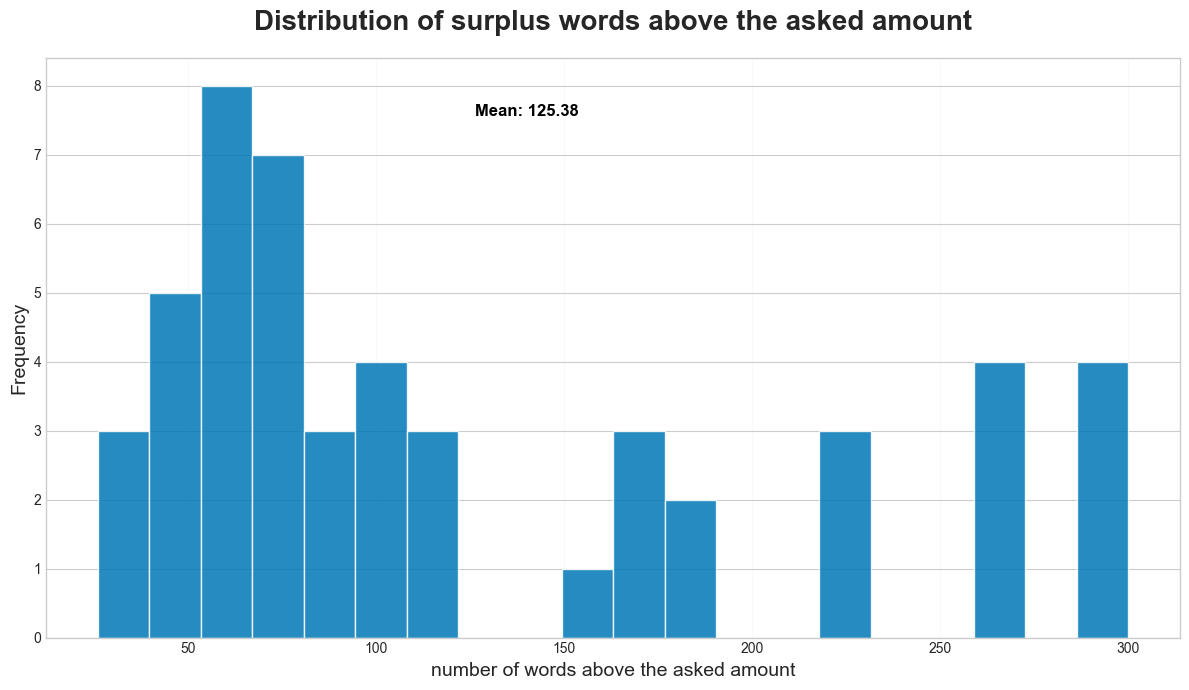

In [68]:
plt.style.use('seaborn-v0_8-whitegrid')
column_name = 'diff_word_count_grok_prompt2'
fig, ax = plt.subplots(figsize=(12, 7))
mean_value = df_news_80[column_name].mean()
n, bins, patches = ax.hist(df_news_80[column_name], bins=20, edgecolor='white', color='#0077B6', alpha=0.85)
ax.text(mean_value + 1, ax.get_ylim()[1] * 0.9, f'Mean: {mean_value:.2f}',
        color='black', fontsize=12, fontweight='bold', ha='left')
ax.set_title(f'Distribution of surplus words above the asked amount', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('number of words above the asked amount', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.grid(axis='x', linestyle='-', alpha=0.1)
max_freq_bin_index = np.argmax(n)
max_freq = n[max_freq_bin_index]
max_freq_bin_center = (bins[max_freq_bin_index] + bins[max_freq_bin_index+1]) / 2
plt.tight_layout()
plt.show()
